## Matrix Factorisation for Collaborative Filtering

This notebook is the implementation of a collaborative filtering for recommandation system using **matrix factorisation**. 
Matrix factorisation algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. The idea is to learn the latent features that describe the characteristics of the items and the preferences of the users. We can then use these latent features to predict the ratings of the items that the users have not interacted with.

In [2]:
import pandas as pd
from scipy.sparse import csr_matrix

data = pd.read_csv('./data/ratings.csv') #import ratings data
display(data.head())

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [36]:
data.rename(columns={'book_id': 'item_id'}, inplace=True)

In [37]:
max_user_id = data['user_id'].max()
max_item_id = data['item_id'].max()

In [38]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
print(train.shape, test.shape)

(4781183, 3) (1195296, 3)


We create a sparse ratings matrix that we will factorise to obtain the latent features. We will use the **Alternating Least Squares (ALS)** algorithm to factorise the matrix. The ALS algorithm is an iterative optimisation algorithm that alternates between fixing one of the matrices and optimising the other. We will use the **implicit** library to implement the ALS algorithm.

In [39]:
# Create a sparse matrix of item/user interactions
ratings = csr_matrix(
    (train.rating.values, (train.user_id.values, train.item_id.values)), 
    shape=(max_user_id + 1, max_item_id + 1)
).toarray()

In [40]:
import time, numpy as np
import matplotlib.pyplot as plt

class MatrixFactorization():
    
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # eta0 Constant that multiplies the update term
        self.alpha = alpha  # lambda Constant that multiplies the regularization term
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False
        
    def initialize(self, ):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # initialize user & item vectors        
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)
        
        
    def predict(self, u, i):
        return self.global_bias+self.user_biases[u]+self.item_biases[i]+self.user_vecs[u]@self.item_vecs[i]
        
    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate*(error - self.alpha*self.user_biases[u])
        self.item_biases[i] += self.l_rate*(error - self.alpha*self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate*(error*self.item_vecs[i, :] - self.alpha*self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate*(error*self.user_vecs[u, :] - self.alpha*self.item_vecs[i, :])
        
    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            # Extracting user item information indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i]-pred_rat)**2
        mse = tot_square_error/self.n_interac
        self.mse_lst.append(mse)
        if self.verbose: 
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time()-self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")
        
    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time()-self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0
        
    def fit(self, ):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if self.stop == False:
                for index in self.ind_lst:
                    # Extracting user item information indices in which we have a rating
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i]-pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.plot_the_score()
                
    def plot_the_score(self, ):
        plt.figure(figsize=(18,6))
        plt.plot(range(1, 1+len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("SGD Custom Prepared USER & ITEM vector's Tr MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num+5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst),15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 0.983 ===> Total training time: 16.177 seconds.
---> Epoch 1
ave mse 0.749 ===> Total training time: 119.175 seconds.
---> Epoch 2
ave mse 0.72 ===> Total training time: 214.323 seconds.
---> Epoch 3
ave mse 0.704 ===> Total training time: 313.533 seconds.
---> Epoch 4
ave mse 0.685 ===> Total training time: 407.95 seconds.
---> Epoch 5
ave mse 0.657 ===> Total training time: 496.832 seconds.
---> Epoch 6
ave mse 0.621 ===> Total training time: 586.723 seconds.
---> Epoch 7
ave mse 0.582 ===> Total training time: 678.863 seconds.
---> Epoch 8
ave mse 0.542 ===> Total training time: 771.52 seconds.
---> Epoch 9
ave mse 0.502 ===> Total training time: 869.938 seconds.
---> Epoch 10
ave mse 0.464 ===> Total training time: 972.242 seconds.
---> Epoch 11
ave mse 0.429 ===> Total training time: 1072.039 seconds.
---> Epoch 12
ave mse 0.396 ===> Total training time: 1179.372 seconds.
---> Epoch 13
ave mse 0.366 ===> Total training time: 1291.367 seconds.
---> Epoch 14
ave

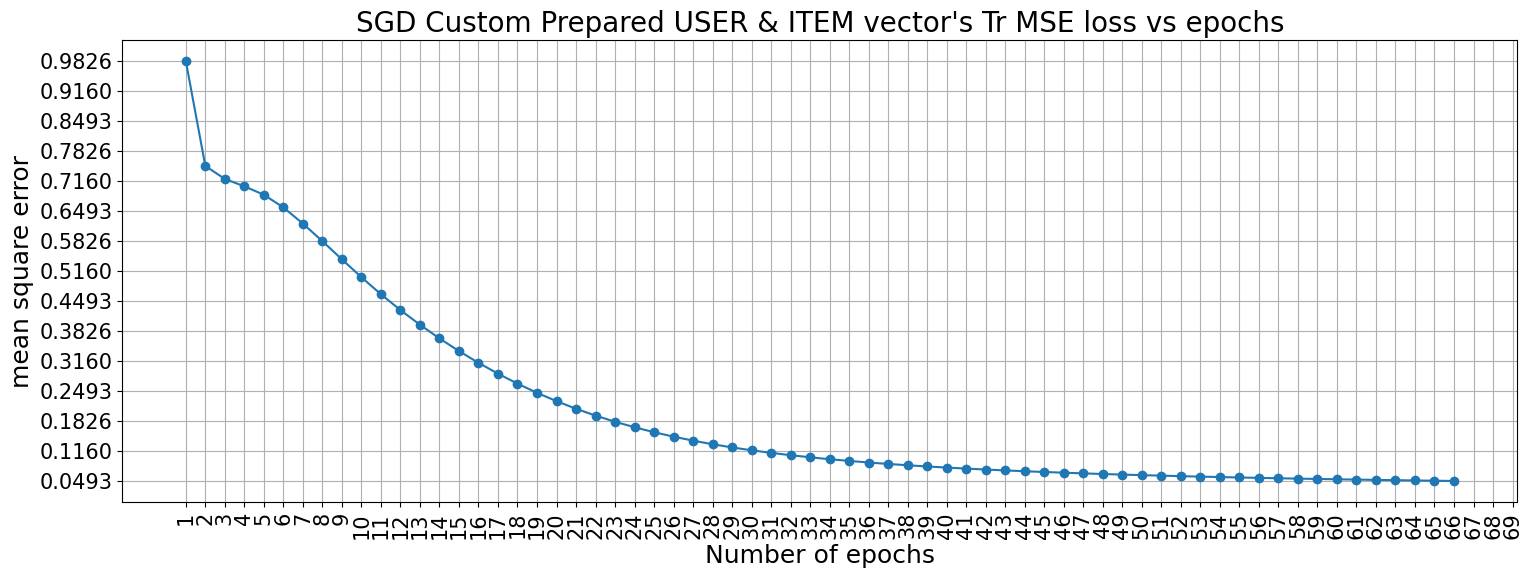

In [42]:
obj = MatrixFactorization(ratings)
obj.fit()

Now that we have optimize the matrices we can use them to predict the ratings of the items that the users have not interacted with in the training dataset. We will test the performance by predicting the ratings that are in the test dataset and comparing them to the actual ratings.

In [45]:
#predict the test data
test['pred'] = test.apply(lambda x: obj.predict(x['user_id'], x['item_id']), axis=1)
test.head()

,user_id,item_id,rating,pred
3623535,42562,2757,3,4.414272
3985638,43232,134,4,3.449099
2983642,37244,1463,5,4.533330
5812251,53366,71,2,1.860146
2208852,29634,3339,4,3.515795


In [46]:
#perform mse on test data
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['rating'], test['pred'])
print(f"Test MSE: {mse}")

Test MSE: 0.8690089509525946


In [51]:
# rmse on the test data
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

Test RMSE: 0.9730879621323847


In [47]:
test['discrete_pred'] = np.round(test['pred']).astype(int)
test.head()

,user_id,item_id,rating,pred,discrete_pred
3623535,42562,2757,3,4.414272,4
3985638,43232,134,4,3.449099,3
2983642,37244,1463,5,4.533330,5
5812251,53366,71,2,1.860146,2
2208852,29634,3339,4,3.515795,4


In [49]:
test.to_csv('./data/results/test_pred_matrix_facto.csv', index=False)

We can see that the performance of the model is quite good with an RMSE of 0.97. This means that the model is able to predict the ratings of the items that users have not interacted with with an average error of 0.97 stars. 

This indicates that while the model may not be able to predict the exact rating, it is generally capable of predicting whether a user will like a book or not. Since the goal of the model is to recommend books that the user will like rather than to predict the exact rating, this is considered a good result.


this method is inspire by the blog page: 

https://medium.com/@rebirth4vali/implementing-matrix-factorization-technique-for-recommender-systems-from-scratch-7828c9166d3c
